In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score

In [44]:
# Download MNIST dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

# Split into training and testing sets
# NOTE y labels should be IGNORED completely ignored by the algorithms,
# however, we will use them to measure the quality of clustering
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Normalize pixel values to a range [0-1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 784) (35000, 784) (35000,) (35000,)


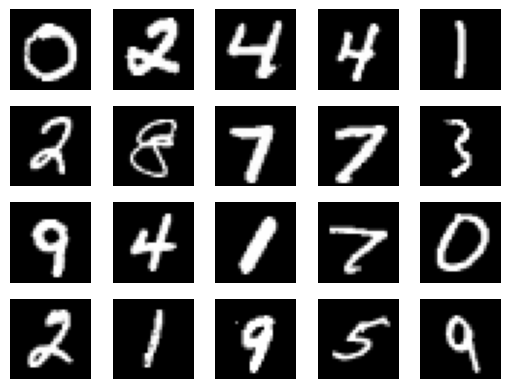

In [45]:
# Plot 20 random images in 4 x 5 grid.
n_samples = 20
# Random images, and no duplicates
random_idx = np.random.choice(X.shape[0], n_samples, replace=False)
for idx in range(n_samples):
    plt.subplot(4, 5, idx + 1)
    plt.imshow(X[random_idx[idx]].reshape(28, 28), cmap='gray')
    plt.axis('off')

In [46]:
# K-Means Clustering Algorithm
algo = KMeans(n_clusters=10, init = 'random', n_init= 'auto')
algo.fit(X_train)
pred = algo.fit_predict(X_test)
homogeneity = homogeneity_score(y_test, pred)
print(f'Homogeneity Score: {homogeneity:.2f}')

Homogeneity Score: 0.50
